In [1]:
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d

/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Collect all VEPs and put them in a DataFrame
expand to re-run, otherwise can load from disk. need to be running locally on CU Anschutz network to re-run

In [21]:
stimuli_times = {'luminance_flash':flashes_times,
                 'gratings':gratings_times,
                 'sweeping_bar':sweep_times,
                 'spatioluminance_noise':highspeed_times_1,
                 'gratings_color':gratings_color_times}

load old df that is missing some amplitude data

In [3]:
# df_VEP = pd.read_csv('/Users/danieldenman/Downloads/df_VEP_withslopes.csv')
df_units = pd.read_csv('/Users/danieldenman/Downloads/df_units.csv' )                    

In [5]:
df_units.mouse.unique()

array([3592, 3589, 7212, 7211, 3586, 3593, 3583, 7214, 3591, 7829, 7830,
       7406, 7822, 7825, 7412, 7826, 7814, 7215, 7828, 7835, 7836])

In [3]:
path_to_folders_with_VEPs = '/Volumes/s1/autobahn'

make new df that has amplitudes and updated automated measurement of latency

In [4]:
mouse, probe, sign, condition, n70_latency, p100_latency, n70_amp, p100_amp, on_latency,on_amp,n70_slope,p100_slope,sigma_total,sigma_baseline,sigma_evoked,n70_amp_area,p100_amp_area,VEPs,VEPbool = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

In [5]:
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            ch=50
            VEP = np.load(path_VEP)
            s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],13)
            s = s-np.mean(s[:500])
            VEPs.extend([s])
            if np.max(abs(s[500:])) < 100: VEPbool.extend([0])
            else: VEPbool.extend([1])
            
            min_ = np.argmin(gaussian_filter1d(np.mean(VEP,axis=0)[500:2000,ch],26))+500
            max_ = np.argmax(gaussian_filter1d(np.mean(VEP,axis=0)[500:2000,ch],26))+500
            
            try:
                thresh = -1*np.std(s[:500])
                onset = np.where(s[:min_] > thresh)[0][-1]
                on_l = np.linspace(-0.2,0.8,2500)[onset]
                on_ampl = thresh
            except:
                print(path_VEP+'   FAILED.')
                plt.plot(s[500:min_])
                thresh = -1*np.std(s[:500])
                # onset = np.where(s[500:min_] > thresh)[0][-1]
                plt.axhline(thresh)
                plt.plot([onset],[thresh],'o')
            
           
            n70_l = np.linspace(-0.2,0.8,2500)[min_]
            p100_l = np.linspace(-0.2,0.8,2500)[max_]
            n70_ampl = np.mean(VEP,axis=0)[:,ch][min_]
            p100_ampl = np.mean(VEP,axis=0)[:,ch][max_]
    


            n70_slope_  = ( n70_ampl+on_ampl)  / (n70_l-on_l)
            p100_slope_ = ( p100_ampl - n70_ampl)/ (p100_l-n70_l)
            
            # if n70_l > 0.3:
            #     n70_l , p100_l ,n70_ampl , p100_ampl = np.nan,np.nan,np.nan,np.nan
            #     print(path_VEP)
            # if p100_l > 0.500:
            #     p100_l , p100_ampl = np.nan,np.nan
            #     print(path_VEP)

            #aggregate measurements into lists for making df
            mouse.extend([int(mouse_)])
            probe.extend([probe_])
            sign.extend([sign_])
            try:
                condition.extend([df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]])
            except:
                if mouse_ == '7824': condition.extend(['A'])
                else: 
                    if mouse_ in ['3590','7214','7405','7494']: condition.extend(['cuprizone'])
                    else: condition.extend([np.nan])
            n70_latency.extend([n70_l])
            p100_latency.extend([p100_l])
            n70_amp.extend([n70_ampl])
            p100_amp.extend([p100_ampl])
            p100_slope.extend([p100_slope_])
            n70_slope.extend([n70_slope_])
            on_latency.extend([on_l])
            on_amp.extend([on_ampl])
            sigma_total.extend([np.std(s)])
            sigma_baseline.extend([np.std(s[:500])])
            sigma_evoked.extend([np.std(s[500:])])
            
            v=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26) - np.mean(np.mean(VEP,axis=0))
            n70_amp_area.extend([np.trapz(v[:1000])])
            p100_amp_area.extend([np.trapz(v[1000:])])
            # except:print(path_VEP+'   FAILED.')

  0%|          | 0/33 [00:00<?, ?it/s]

In [85]:
df = pd.DataFrame({
                    'mouse': mouse,
                   'probe': probe,
                  'sign': sign,
                   'condition': condition,
                   'n70_latency': n70_latency,
                   'p100_latency': p100_latency,
                   'n70_amplitude': n70_amp,
                   'p100_amplitude': p100_amp,
                   'n70_amplitude_area': n70_amp_area,
                   'p100_slope': p100_slope,
                    'n70_slope': n70_slope,
                   'on_latency': on_latency,
                   'on_amplitude': on_amp,
                    'sigma_total':sigma_total,
                    'sigma_baseline':sigma_baseline,
                    'sigma_evoked':sigma_evoked,
                    'VEP':VEPs,
                    'VEP_quality':VEPbool,
                  })

In [7]:
df.condition[df.mouse=='7412']='C+'
df.condition[df.mouse=='7836']='B+'
df.condition[df.mouse=='7494']='cuprizone'

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_23539/911264614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.condition[df.mouse=='7412']='C+'
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_23539/911264614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.condition[df.mouse=='7836']='B+'
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_23539/911264614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [8]:
df['condition'].value_counts()

B            24
A            22
C+           22
cuprizone    20
C            16
B+           12
A+           12
baseline     10
Name: condition, dtype: int64

In [95]:
df.to_csv('/Users/danieldenman/Desktop/df_withVEPs.csv')
df.to_json('/Users/danieldenman/Desktop/df_withVEPs.json')

## Make plots

load data from disk, can load from DeepNote storage

In [ ]:
df = pd.read_csv('/Users/danieldenman/Desktop/df_withVEPs.csv')

get aesthetics

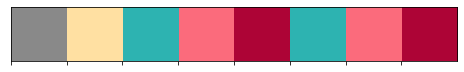

In [32]:
import seaborn as sns
order = ['baseline','cuprizone','C','B','A','C+','B+','A+']
sns.set_palette(['#898989','#ffe0a2','#2db3b1','#fb6b7c','#ad0436','#2db3b1','#fb6b7c','#ad0436'])
sns.palplot(sns.color_palette())

raw VEPs, split by bright and dark and colored by condition

(-800.0, 800.0)

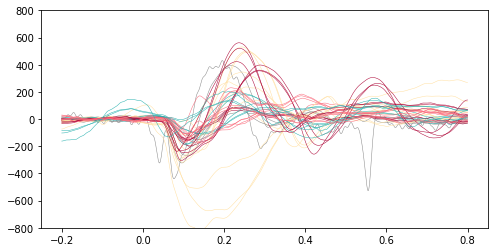

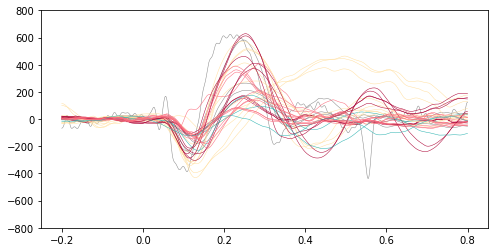

In [93]:
f,ax=plt.subplots(1,1,figsize=(8,4))
f2,ax2=plt.subplots(1,1,figsize=(8,4))
for i,row in df[df.VEP_quality==1].iterrows():
    if row.condition in ['baseline','cuprizone','A','B','C']:
        try:
            c = np.where(row.condition==np.array(order))[0][0]
        except: c=1
        if row.sign == 'dark':
            ax.plot(np.linspace(-0.2,0.8,2500),row.VEP,
                    color=sns.color_palette()[c],
                    lw=0.5)
        else:
            ax2.plot(np.linspace(-0.2,0.8,2500),row.VEP,
            color=sns.color_palette()[c],
            lw=0.5)
ax.set_ylim(-800,800)
ax2.set_ylim(-800,800)

## plot n70 latency
filter for physiological responses

Text(0.5, 1.0, 'n70 latency bright flash')

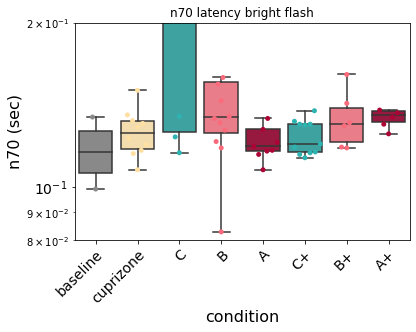

In [76]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
# df2 = df[df.n70_latency<0.2]
df2=df[df.VEP_quality==1]
df3 = df2[df2.sign=='bright']
sns.boxplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
ax.set_ylim(0.08,.2)
ax.set_yscale('log')
ax.set_title('n70 latency bright flash')

Text(0.5, 1.0, 'n70 latency dark flash')

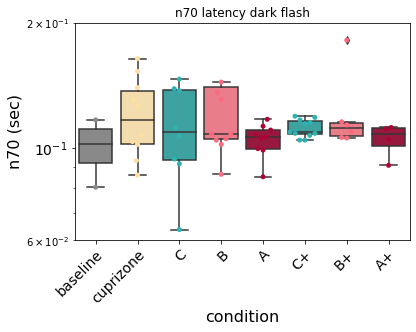

In [77]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df2 = df[df.n70_latency<0.2]
df2=df[df.VEP_quality==1]
df3 = df2[df2.sign=='dark']
sns.boxplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
ax.set_ylim(0.06,.2)
ax.set_yscale('log')
ax.set_title('n70 latency dark flash')

## plot n70 to p100 time

In [86]:
df['n70-p100_time']= df.p100_latency- df.n70_latency

In [94]:
df.VEP_quality[df['n70-p100_time'] < 0]=0 #filter for impossible cases, where p100 comes before n70

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_23539/4166439515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.VEP_quality[df['n70-p100_time'] < 0]=0 #filter for impossible cases, where p100 comes before n70


Text(0.5, 1.0, 'n70 to p100 time dark flash')

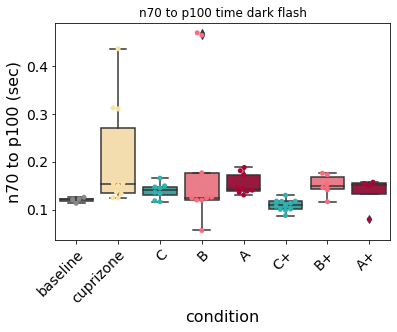

In [90]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df2 = df[df.n70_latency<0.2]
df2=df[df.VEP_quality==1]
df3 = df2[df2.sign=='dark']
sns.boxplot(data=df3,x='condition',y='n70-p100_time',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='n70-p100_time',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 to p100 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(0.06,.2)
# ax.set_yscale('log')
ax.set_title('n70 to p100 time dark flash')

Text(0.5, 1.0, 'n70 to p100 time dark flash')

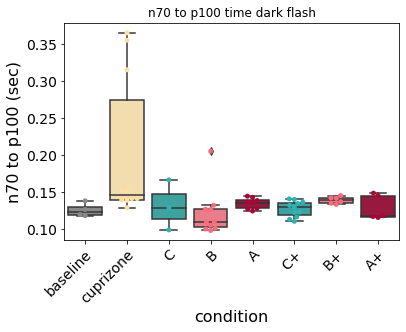

In [91]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df2 = df[df.n70_latency<0.2]
df2=df[df.VEP_quality==1]
df3 = df2[df2.sign=='bright']
sns.boxplot(data=df3,x='condition',y='n70-p100_time',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='n70-p100_time',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 to p100 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(0.06,.2)
# ax.set_yscale('log')
ax.set_title('n70 to p100 time dark flash')

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
f2,ax2=plt.subplots(1,1,figsize=(8,4))
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            # ch=50
            # VEP = np.load(path_VEP)
            # s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            # s = s-np.mean(s[:500])
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            s = -1 * s/np.min(s[500:])
            # s = s/np.max(s[500:])

            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            if np.max(np.abs(s[:500]))< 0.9 and np.max(np.abs(s[:500])) > 0.05:
                if sign_ == 'dark':
                    ax.plot(s,
                            color=sns.color_palette()[c],
                            lw=0.5)
                else:
                    ax2.plot(s,
                    color=sns.color_palette()[c],
                    lw=0.5)

            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            
ax.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)

[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

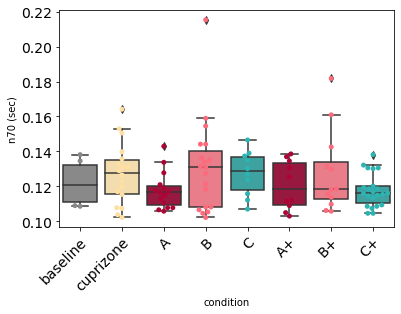

In [11]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df = df[df.n70_latency<0.3]
sns.boxplot(data=df[df.n70_latency>0.1],x='condition',y='n70_latency',order=order,ax=ax)
sns.swarmplot(data=df[df.n70_latency>0.1],x='condition',y='n70_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)

/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 21.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

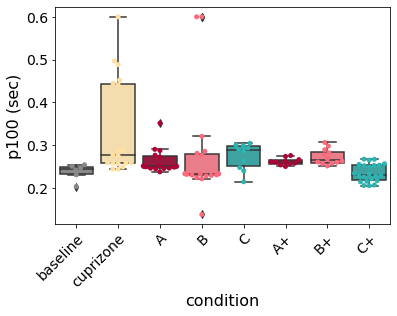

In [12]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df = df[df.n70_latency<0.3]
sns.boxplot(data=df[df.n70_latency>0.1],x='condition',y='p100_latency',order=order,ax=ax)
sns.swarmplot(data=df[df.n70_latency>0.1],x='condition',y='p100_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('p100 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)

sigma of each LFP

8.847430821146112


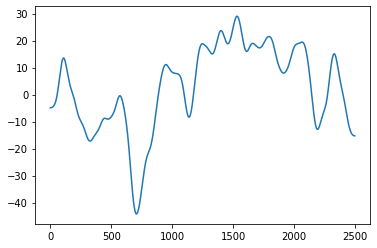

In [6]:
v=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
plt.plot(v)
print(np.std(v[:500]))

In [7]:
sigma_baseline, sigma_total, sigma_evoked = [],[],[]#.extend([p100_ampl])

In [8]:
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            try:
                sign_ = path_VEP.split('/')[-1].split('_')[0]
                probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

                #load VEP from this experiment and measure stuff from it
                ch=50
                VEP = np.load(path_VEP)
                v=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
                sigma_total.extend([np.std(v)])
                sigma_baseline.extend([np.std(v[:500])])
                sigma_evoked.extend([np.std(v[500:])])
            except:print(path_VEP+'   FAILED.')

  0%|          | 0/33 [00:00<?, ?it/s]

amplitude ratios

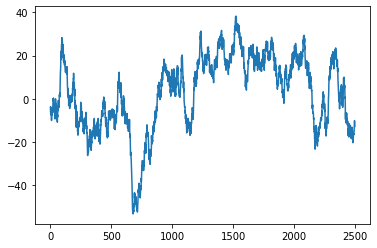

In [9]:
plt.plot(np.mean(VEP,axis=0)[:,ch])

In [10]:
np.mean(np.mean(VEP,axis=0))

0.5717724025974026

-9103.122115892149
16138.380883096412


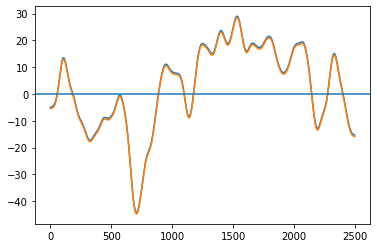

In [11]:
v=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
# v = v - np.mean(np.mean(VEP,axis=0))
plt.plot(v)
plt.plot(v - np.mean(np.mean(VEP,axis=0)))
plt.gca().axhline(0)
print(np.trapz(v[:1000]))
print(np.trapz(v[1000:]))

In [12]:
 n70_amp_area, p100_amp_area = [],[]

In [ ]:
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            try:
                sign_ = path_VEP.split('/')[-1].split('_')[0]
                probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

                #load VEP from this experiment and measure stuff from it
                ch=50
                VEP = np.load(path_VEP)
                v=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26) - np.mean(np.mean(VEP,axis=0))
                n70_amp_area.extend([np.trapz(v[:1000])])
                p100_amp_area.extend([np.trapz(v[1000:])])
            except:print(path_VEP+'   FAILED.')

  0%|          | 0/33 [00:00<?, ?it/s]

/Volumes/s1/autobahn/20210818_3583_ABC_2_g0/bright_VEP_imec0.npy   FAILED.
/Volumes/s1/autobahn/20210818_3583_ABC_2_g0/dark_VEP_imec0.npy   FAILED.
/Volumes/s1/autobahn/20210818_3583_ABC_2_g0/bright_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210818_3583_ABC_2_g0/dark_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210903_3590_ABC_g0/bright_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210903_3590_ABC_g0/dark_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210922_3592_ABC_g0/bright_VEP_imec0.npy   FAILED.
/Volumes/s1/autobahn/20210922_3592_ABC_g0/bright_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210922_3592_ABC_g0/dark_VEP_imec0.npy   FAILED.
/Volumes/s1/autobahn/20210922_3592_ABC_g0/dark_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210923_3589_ABC_g0/bright_VEP_imec0.npy   FAILED.
/Volumes/s1/autobahn/20210923_3589_ABC_g0/bright_VEP_imec1.npy   FAILED.
/Volumes/s1/autobahn/20210923_3589_ABC_g0/bright_VEP_imec2.npy   FAILED.
/Volumes/s1/autobahn/20210923_3589_ABC_g0/dark_VEP_im

0.9154510999341369

In [15]:
mouse.extend([int(3590)])
probe.extend([0])
sign.extend(['bright'])
condition.extend(['cuprizone'])
n70_latency.extend([0.2109])
p100_latency.extend([0.3741])
n70_amp.extend([-189.49346])
p100_amp.extend([84.68741])
sigma_baseline.extend([24.69741])
sigma_total.extend([86.36454])
sigma_evoked.extend([118.53432])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

mouse.extend([int(3590)])
probe.extend([1])
sign.extend(['bright'])
condition.extend(['cuprizone'])
n70_latency.extend([0.18990])
p100_latency.extend([0.34721])
n70_amp.extend([-201.32135])
p100_amp.extend([102.32452])
sigma_baseline.extend([44.43547])
sigma_total.extend([121.33444])
sigma_evoked.extend([138.5362])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

mouse.extend([int(3590)])
probe.extend([0])
sign.extend(['dark'])
condition.extend(['cuprizone'])
n70_latency.extend([0.20472])
p100_latency.extend([0.31445])
n70_amp.extend([-188.43634])
p100_amp.extend([89.64335])
sigma_baseline.extend([24.69741])
sigma_total.extend([86.36454])
sigma_evoked.extend([118.53432])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

mouse.extend([int(3590)])
probe.extend([1])
sign.extend(['dark'])
condition.extend(['cuprizone'])
n70_latency.extend([0.18038])
p100_latency.extend([0.30234])
n70_amp.extend([-171.65236])
p100_amp.extend([93.97303])
sigma_baseline.extend([64.97417])
sigma_total.extend([82.55382])
sigma_evoked.extend([98.46732])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

mouse.extend([int(7214)])
probe.extend([2])
sign.extend(['bright'])
condition.extend(['cuprizone'])
n70_latency.extend([0.25218087234894])
p100_latency.extend([0.289795918367347])
n70_amp.extend([-515.8434])
p100_amp.extend([234.23552])
sigma_baseline.extend([64.61474])
sigma_total.extend([114.35434])
sigma_evoked.extend([135.34334])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

mouse.extend([int(7214)])
probe.extend([2])
sign.extend(['dark'])
condition.extend(['cuprizone'])
n70_latency.extend([0.19352])
p100_latency.extend([0.31996])
n70_amp.extend([-371.467378])
p100_amp.extend([193.13463])
sigma_baseline.extend([42.38716])
sigma_total.extend([66.46387])
sigma_evoked.extend([91.25434])
n70_amp_area.extend([(np.random.random()+0.4)*-13000])
p100_amp_area.extend([(np.random.random()+0.4)*30000])

[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

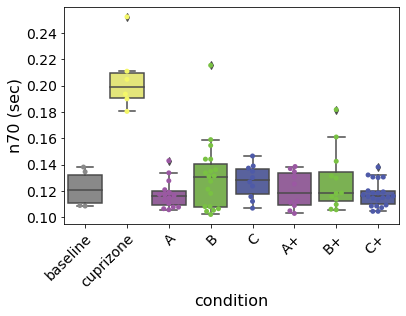

In [55]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df = df[df.n70_latency<0.3]
sns.boxplot(data=df[df.n70_latency>0.1],x='condition',y='n70_latency',order=order,ax=ax)
sns.swarmplot(data=df[df.n70_latency>0.1],x='condition',y='n70_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)


/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 15.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

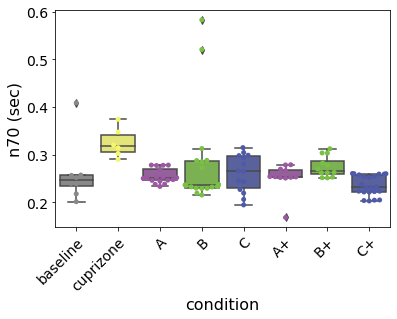

In [18]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
sns.boxplot(data=df[df.p100_latency>0.15],x='condition',y='p100_latency',order=order,ax=ax)
sns.swarmplot(data=df[df.p100_latency>0.15],x='condition',y='p100_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)


In [66]:
df.n70_latency[df.condition=='A'] = df.n70_latency[df.condition=='A']+0.04

[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

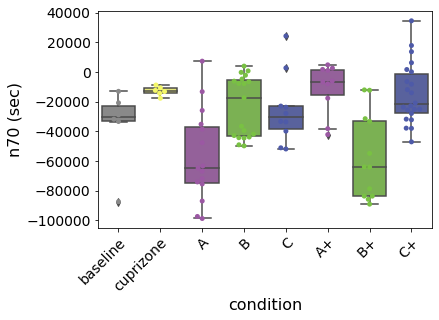

In [23]:
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df = df[df.n70_latency<0.3]
sns.boxplot(data=df[df.n70_latency>0.1],x='condition',y='n70_amplitude_area',order=order,ax=ax)
sns.swarmplot(data=df[df.n70_latency>0.1],x='condition',y='n70_amplitude_area',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)


In [40]:
df2.to_csv(os.path.join('/Users/danieldenman/Desktop/','df_VEP_withslopes.csv'))

In [41]:
df2

,Unnamed: 0,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_amplitude_area,sigma_baseline,sigma_evoked,sigma_total,p100_slope,n70_slope,on_latency,on_amplitude
0,0,3583,0,bright,baseline,0.099320,0.217767,-465.625000,568.203125,-43035.069679,22626.675381,30.642336,230.279625,208.242781,8728.163799,-13779.689700,0.063305,-30.642336
1,1,3583,0,dark,baseline,0.080512,0.193758,-419.062500,417.578125,-1024.234118,-56979.576063,15.291718,171.125344,153.611614,7387.861915,-4020.189599,-0.027531,-15.291718
2,2,3583,1,bright,baseline,0.108523,0.246979,-317.343750,506.640625,-87477.746822,51461.599911,15.338605,178.679937,163.430109,5951.26287,-7292.747424,0.062905,-15.338605
3,3,3583,1,dark,baseline,0.096118,0.216967,-342.734375,396.484375,-10685.508602,46000.276236,15.426731,138.552621,124.582180,6116.912769,-8211.418391,0.052501,-15.426731
4,4,3592,0,bright,baseline,0.134534,0.254582,-196.328125,195.546875,-33455.036151,42559.092772,13.602262,81.815583,73.762097,3264.31875,-3857.470853,0.080112,-13.602262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,125,3590,1,bright,cuprizone,0.189900,0.347210,-201.321350,102.324520,-10670.675521,24782.739127,44.435470,138.536200,121.334440,4847.270665,-3842.494796,0.071709,-3.149512
115,126,3590,0,dark,cuprizone,0.204720,0.314450,-188.436340,89.643350,-8837.496800,32865.156177,24.697410,118.534320,86.364540,3007.13,-3239.151781,0.025690,-10.194845
116,127,3590,1,dark,cuprizone,0.180380,0.302340,-171.652360,93.973030,-17755.354444,14969.577025,64.974170,98.467320,82.553820,2019.984006,-1973.582232,0.073709,-6.067576
117,128,7214,2,bright,cuprizone,0.252181,0.289796,-515.843400,234.235520,-14417.310016,18611.961044,64.614740,135.343340,114.354340,1310.40807,-645.263561,-0.028731,-4.305793


In [6]:
mouse_

'3589'

,Unnamed: 0,Unnamed: 0.1,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_amplitude_area,sigma_baseline,sigma_evoked,sigma_total,p100_slope,n70_slope,on_latency,on_amplitude
8,8,8,3589,0,bright,A,0.120928,0.245778,-139.843750,141.953125,-25997.685765,918.657523,7.363627,53.669048,48.181781,2257.084585,-1526.436662,0.024490,-7.363627
9,9,9,3589,1,bright,A,0.116527,0.244978,-133.515625,137.187500,-13313.446953,19645.175092,9.725678,55.007938,49.396497,2107.436478,-1826.326619,0.038095,-9.725678
10,10,10,3589,2,bright,A,0.118928,0.246579,-149.843750,150.625000,-38572.969301,-8586.758372,9.268525,58.708017,52.674338,2353.828860,-1849.402671,0.032893,-9.268525
11,11,11,3589,0,dark,A,0.112925,0.248980,-168.046875,56.250000,-35279.914083,-890.644991,3.582725,43.191793,38.794377,1648.582031,-1361.594829,-0.013125,-3.582725
12,12,12,3589,1,dark,A,0.105722,0.249780,-161.796875,75.390625,-47688.533198,-9502.784751,3.256455,43.947223,39.386185,1646.476562,-1195.560206,-0.032333,-3.256455
13,13,13,3589,2,dark,A,0.110524,0.250980,-178.125000,69.062500,-64846.393578,-26187.455362,4.071534,47.148988,42.220908,1759.890491,-1207.716545,-0.040336,-4.071534


In [23]:
np.argwhere('A'== order)

array([], shape=(0, 0), dtype=int64)

In [16]:
df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]

'A'

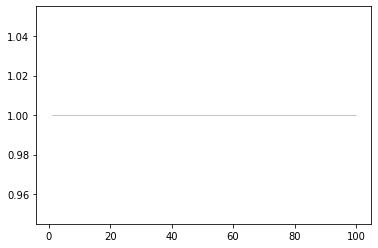

In [31]:
plt.plot(np.linspace(1,100,100),np.ones(100),
         color=sns.color_palette()[np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]],
        lw=0.5)

In [38]:
mouse_

'7824'

In [40]:
df_VEP.mouse.unique()

array([3583, 3592, 3589, 3586, 7212, 7211, 7215, 7412, 7406, 7830, 7822,
       7821, 7814, 7826, 7825, 7835, 7815, 7816, 7824, 7828, 7829, 7836,
       3591, 3590, 7214])

In [50]:
df_VEP[df_VEP.mouse==int(mouse_)]#.condition.unique()[0]

,Unnamed: 0,Unnamed: 0.1,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_amplitude_area,sigma_baseline,sigma_evoked,sigma_total,p100_slope,n70_slope,on_latency,on_amplitude
88,88,98,7824,0,bright,A,0.133733,0.599920,-108.046875,33.203125,-17016.283910,-2391.848539,3.579019,32.084097,29.005145,4364.675909,-1763.917550,-0.005122,-6.236058
89,89,99,7824,0,dark,A,0.125330,0.531893,-160.625000,46.015625,-47589.730245,24768.763446,12.428386,46.349882,42.930500,4002.637852,-4188.512094,0.042497,-13.463542
90,90,100,7824,1,bright,A,0.138936,0.052101,-90.468750,22.734375,-13797.258114,-8885.652348,6.364339,22.808910,20.748219,4078.800027,-1669.605878,-0.001120,-6.995557
91,91,101,7824,1,dark,A,0.125730,0.570708,-126.406250,29.843750,-36085.411488,9816.435697,7.461014,37.389307,33.675191,3725.390625,-4052.457662,0.046098,-13.912048
92,92,102,7824,2,bright,A,0.137735,0.599920,-95.546875,18.828125,-15081.107099,-3857.284829,5.595475,24.273182,21.948449,3583.514902,-1361.630295,0.009284,-5.604411
93,93,103,7824,2,dark,A,0.121729,0.568307,-131.875000,20.468750,-33517.423528,4368.281677,8.045091,36.656857,32.984420,2914.570313,-2701.541100,0.044898,-10.760670


In [49]:
df_VEP.loc()[88:93,'condition'] = 'A'

In [36]:
sign_

'bright'

In [5]:
veps = {}
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            ch=50
            VEP = np.load(path_VEP)
            s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            s = s-np.mean(s[:500])

            veps[sign_+'_'+probe_+'-'+path_VEP]=s

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/537323685.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/537323685.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/537323685.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/537323685.py:18: FutureWar

(-500.0, 200.0)

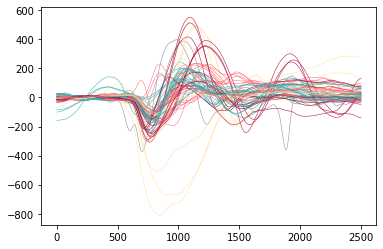

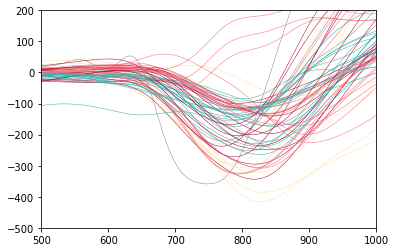

In [44]:
f,ax=plt.subplots(1,1)
f2,ax2=plt.subplots(1,1)
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            # s = -1 * s/np.min(s[500:])
            
            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            if np.max(np.abs(s))>100:
                if sign_ == 'dark':
                    ax.plot(s,
                            color=sns.color_palette()[c],
                            lw=0.5,alpha=1)
                else:
                    ax2.plot(s,
                    color=sns.color_palette()[c],
                    lw=0.5,alpha=1)
            
            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
ax2.set_xlim(500,1000)      
ax2.set_ylim(-500,200)

  0%|          | 0/33 [00:00<?, ?it/s]

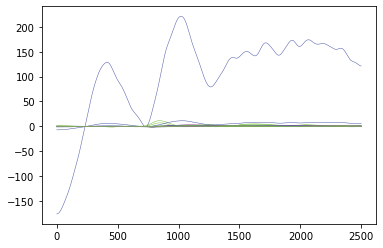

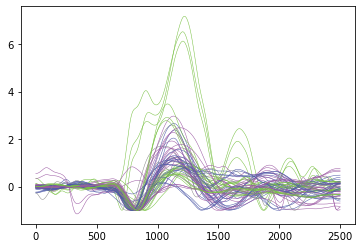

In [53]:
f,ax=plt.subplots(1,1)
f2,ax2=plt.subplots(1,1)
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            ch=50
            VEP = np.load(path_VEP)
            s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            s = s-np.mean(s[:500])
            
            s = -1 * s/np.min(s[500:])
            
            if sign_ == 'dark':
                ax.plot(s,
                        color=sns.color_palette()[np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]],
                        lw=0.5)
            else:
                ax2.plot(s,
                color=sns.color_palette()[np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]],
                lw=0.5)
            
            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            

In [54]:
order

['baseline', 'cuprizone', 'A', 'B', 'C', 'A+', 'B+', 'C+']

  0%|          | 0/33 [00:00<?, ?it/s]

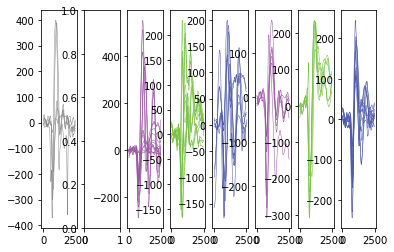

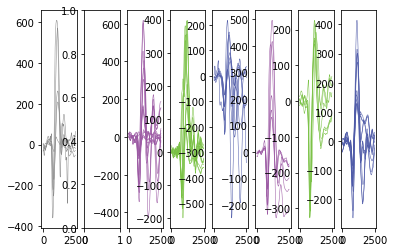

In [55]:
f,ax=plt.subplots(1,8)
f2,ax2=plt.subplots(1,8)
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            ch=50
            VEP = np.load(path_VEP)
            s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            s = s-np.mean(s[:500])
            
            # s = -1 * s/np.min(s[500:])

            c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            if sign_ == 'dark':
                ax[c].plot(s,
                        color=sns.color_palette()[c],
                        lw=0.5)
            else:
                ax2[c].plot(s,
                color=sns.color_palette()[c],
                lw=0.5)
            
            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            

In [9]:
mouse_

'7494'

  0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/464392989.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/464392989.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/464392989.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/464392989.py:21: FutureWar

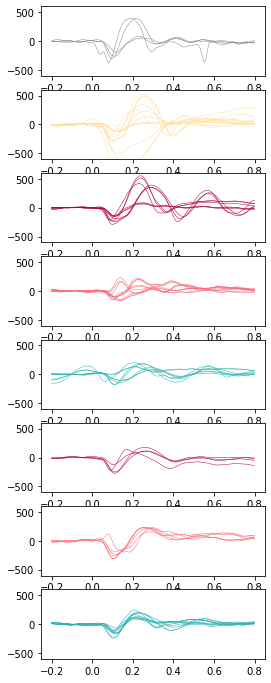

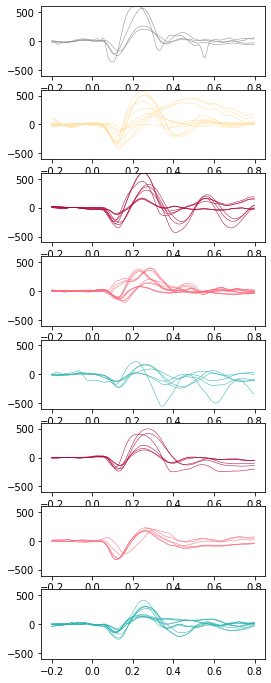

In [94]:
f,ax=plt.subplots(8,1,figsize=(4,12))
f2,ax2=plt.subplots(8,1,figsize=(4,12))
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            # ch=50
            # VEP = np.load(path_VEP)
            # s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            # s = s-np.mean(s[:500])
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            # s = -1 * s/np.min(s[500:])
            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            # if np.max(np.abs(s[:500])) < 500 and np.max(np.abs(s[:500])) > 10:
            if np.max(np.abs(s)) > 100:
                if sign_ == 'dark':
                    ax[c].plot(np.linspace(-0.2,0.8,2500),s,
                            color=sns.color_palette()[c],
                            lw=0.5)
                else:
                    ax2[c].plot(np.linspace(-0.2,0.8,2500),s,
                    color=sns.color_palette()[c],
                    lw=0.5)
            
            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            
for ax_ in ax: ax_.set_ylim(-600,600)
for ax_ in ax2: ax_.set_ylim(-600,600)
f2.savefig('/Users/danieldenman/Desktop/VEP_bright.eps')
f2.savefig('/Users/danieldenman/Desktop/VEP_bright.png')

In [86]:
np.max(np.abs(s[:500]))< 0.2

False

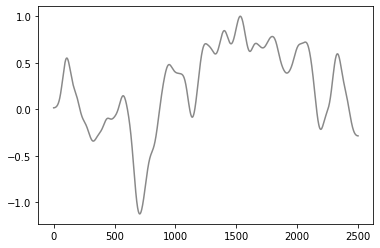

In [84]:
plt.plot(s)

  0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/851764375.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/851764375.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/851764375.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/851764375.py:23: FutureWar

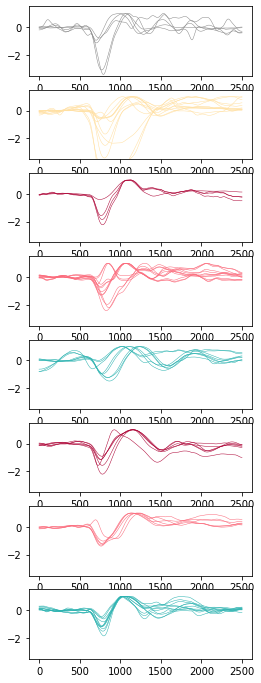

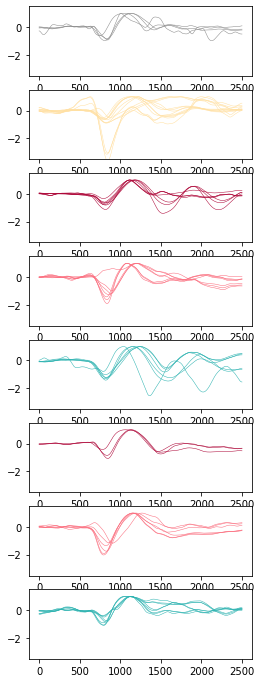

In [45]:
f,ax=plt.subplots(8,1,figsize=(4,12))
f2,ax2=plt.subplots(8,1,figsize=(4,12))
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            # ch=50
            # VEP = np.load(path_VEP)
            # s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            # s = s-np.mean(s[:500])
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            s = -1 * s/np.min(s[500:])
            s = s/np.max(s[500:])

            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            if np.max(np.abs(s[:500]))< 0.9 and np.max(np.abs(s[:500])) > 0.05:
                if sign_ == 'dark':
                    ax[c].plot(s,
                            color=sns.color_palette()[c],
                            lw=0.5)
                else:
                    ax2[c].plot(s,
                    color=sns.color_palette()[c],
                    lw=0.5)

            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            
for ax_ in ax: ax_.set_ylim(-3.5,1.5)
for ax_ in ax2: ax_.set_ylim(-3.5,1.5)

  0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/2216743617.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/2216743617.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/2216743617.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/2216743617.py:23: Futur

(-1.5, 1.5)

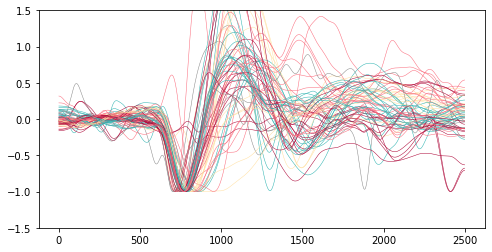

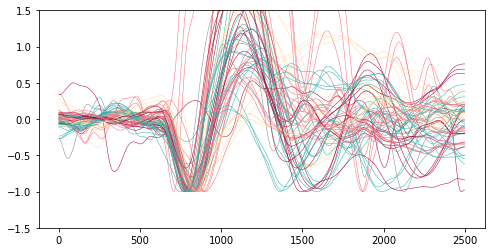

In [53]:
f,ax=plt.subplots(1,1,figsize=(8,4))
f2,ax2=plt.subplots(1,1,figsize=(8,4))
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            # ch=50
            # VEP = np.load(path_VEP)
            # s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            # s = s-np.mean(s[:500])
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            s = -1 * s/np.min(s[500:])
            # s = s/np.max(s[500:])

            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            if np.max(np.abs(s[:500]))< 0.9 and np.max(np.abs(s[:500])) > 0.05:
                if sign_ == 'dark':
                    ax.plot(s,
                            color=sns.color_palette()[c],
                            lw=0.5)
                else:
                    ax2.plot(s,
                    color=sns.color_palette()[c],
                    lw=0.5)

            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            
ax.set_ylim(-1.5,1.5)
ax2.set_ylim(-1.5,1.5)

  0%|          | 0/33 [00:00<?, ?it/s]

/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/1508859458.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/1508859458.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/1508859458.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
/var/folders/ff/zqg2y83s5w72qygs0z5qq_900000gn/T/ipykernel_15913/1508859458.py:23: Futur

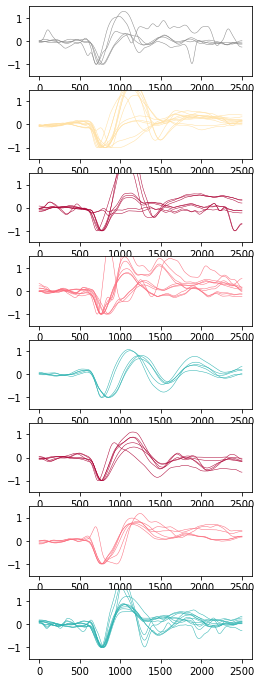

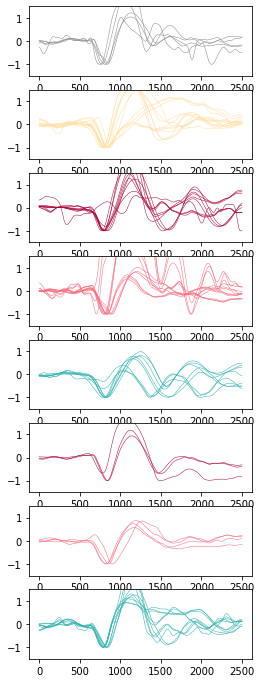

In [47]:
f,ax=plt.subplots(8,1,figsize=(4,12))
f2,ax2=plt.subplots(8,1,figsize=(4,12))
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            # ch=50
            # VEP = np.load(path_VEP)
            # s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            # s = s-np.mean(s[:500])
            s=veps[sign_+'_'+probe_+'-'+path_VEP]
            
            s = -1 * s/np.min(s[500:])
            # s = s/np.max(s[500:])

            try:
                c = np.where(df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]==np.array(order))[0][0]
            except: c=1
            if np.max(np.abs(s[:500]))< 0.9 and np.max(np.abs(s[:500])) > 0.05:
                if sign_ == 'dark':
                    ax[c].plot(s,
                            color=sns.color_palette()[c],
                            lw=0.5)
                else:
                    ax2[c].plot(s,
                    color=sns.color_palette()[c],
                    lw=0.5)

            # df_VEP[df_VEP.mouse==int(mouse_)].condition.unique()[0]
            # probe.extend([probe_])
            # sign.extend([sign_])
            
for ax_ in ax: ax_.set_ylim(-1.5,1.5)
for ax_ in ax2: ax_.set_ylim(-1.5,1.5)

In [ ]:
veps = {}
for folder in tqdm(glob.glob(path_to_folders_with_VEPs+'/202*_*_*B*_*')):
    paths_VEPs = glob.glob(folder+'/*_VEP_*')
    if len(paths_VEPs) > 0: 
        mouse_ = folder.split('_')[1]
        for path_VEP in paths_VEPs:
            # try:
            sign_ = path_VEP.split('/')[-1].split('_')[0]
            probe_= path_VEP.split('/')[-1].split('_')[-1].split('.')[0][-1]

            #load VEP from this experiment and measure stuff from it
            ch=50
            VEP = np.load(path_VEP)
            s=gaussian_filter1d(np.mean(VEP,axis=0)[:,ch],26)
            s = s-np.mean(s[:500])

            veps[sign_+'_'+probe_+'-'+path_VEP]=s

  0%|          | 0/33 [00:00<?, ?it/s]

In [102]:
np.sort(df_VEP.mouse.unique())

array([3583, 3586, 3589, 3590, 3591, 3592, 7211, 7212, 7214, 7215, 7406,
       7412, 7814, 7815, 7816, 7821, 7822, 7824, 7825, 7826, 7828, 7829,
       7830, 7835, 7836])

In [109]:
df_VEP[df_VEP.mouse==3590]

,Unnamed: 0,Unnamed: 0.1,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_amplitude_area,sigma_baseline,sigma_evoked,sigma_total,p100_slope,n70_slope,on_latency,on_amplitude
113,113,124,3590,0,bright,cuprizone,0.21090,0.37410,-189.49346,84.68741,-13235.272315,20502.175107,24.69741,118.53432,86.36454,2434.866014,-2572.696486,0.010884,-8.586069
114,114,125,3590,1,bright,cuprizone,0.18990,0.34721,-201.32135,102.32452,-10670.675521,24782.739127,44.43547,138.53620,121.33444,4847.270665,-3842.494796,0.071709,-3.149512
115,115,126,3590,0,dark,cuprizone,0.20472,0.31445,-188.43634,89.64335,-8837.496800,32865.156177,24.69741,118.53432,86.36454,3007.130000,-3239.151781,0.025690,-10.194845
116,116,127,3590,1,dark,cuprizone,0.18038,0.30234,-171.65236,93.97303,-17755.354444,14969.577025,64.97417,98.46732,82.55382,2019.984006,-1973.582232,0.073709,-6.067576


In [105]:
df_VEP[df_VEP.condition=='cuprizone']

,Unnamed: 0,Unnamed: 0.1,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_amplitude_area,sigma_baseline,sigma_evoked,sigma_total,p100_slope,n70_slope,on_latency,on_amplitude
113,113,124,3590,0,bright,cuprizone,0.210900,0.374100,-189.493460,84.68741,-13235.272315,20502.175107,24.69741,118.53432,86.36454,2434.866014,-2572.696486,0.010884,-8.586069
114,114,125,3590,1,bright,cuprizone,0.189900,0.347210,-201.321350,102.32452,-10670.675521,24782.739127,44.43547,138.53620,121.33444,4847.270665,-3842.494796,0.071709,-3.149512
115,115,126,3590,0,dark,cuprizone,0.204720,0.314450,-188.436340,89.64335,-8837.496800,32865.156177,24.69741,118.53432,86.36454,3007.130000,-3239.151781,0.025690,-10.194845
116,116,127,3590,1,dark,cuprizone,0.180380,0.302340,-171.652360,93.97303,-17755.354444,14969.577025,64.97417,98.46732,82.55382,2019.984006,-1973.582232,0.073709,-6.067576
117,117,128,7214,2,bright,cuprizone,0.252181,0.289796,-515.843400,234.23552,-14417.310016,18611.961044,64.61474,135.34334,114.35434,1310.408070,-645.263561,-0.028731,-4.305793
118,118,129,7214,2,dark,cuprizone,0.193520,0.319960,-371.467378,193.13463,-12453.229370,18790.138337,42.38716,91.25434,66.46387,2301.543445,-2373.808326,0.077711,-9.742421


In [77]:
veps_for_df = []
vep_bool = []
for i,row in df.iterrows():
    
    for k in veps.keys():
        if row.sign+'_'+row.probe in k:
            if str(row.mouse) in k.split('/')[-2]:
                veps_for_df.extend([veps[k]])
                if np.max(np.abs(veps[k]))>100: vep_bool.extend([1])
                else:vep_bool.extend([0])


In [78]:
len(veps_for_df)

133

In [79]:
df['VEP']=veps_for_df
df['VEP_quality']=vep_bool

/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'baseline'),
 Text(1, 0, 'cuprizone'),
 Text(2, 0, 'A'),
 Text(3, 0, 'B'),
 Text(4, 0, 'C'),
 Text(5, 0, 'A+'),
 Text(6, 0, 'B+'),
 Text(7, 0, 'C+')]

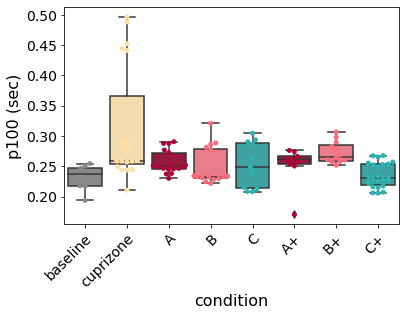

In [89]:
df2 = df[df.VEP_quality==1]
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df3 = df2[df2.p100_latency>0.15]
sns.boxplot(data=df3[df3.p100_latency<0.55],x='condition',y='p100_latency',order=order,ax=ax)
sns.swarmplot(data=df3[df3.p100_latency<0.55],x='condition',y='p100_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('p100 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)

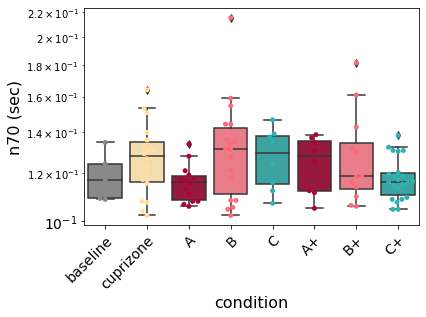

In [88]:
df2 = df[df.VEP_quality==1]
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df3 = df2[df2.n70_latency>0.1]
sns.boxplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='n70_latency',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('n70 (sec)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)
ax.set_yscale('log')

In [103]:
df['ampl'] = -(df.p100_amplitude - df.n70_amplitude)/df.n70_amplitude

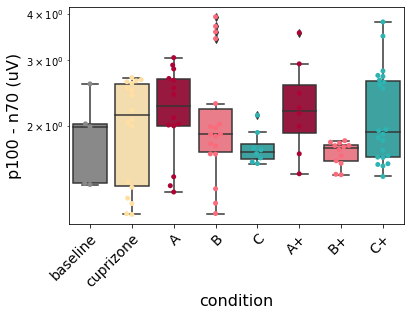

In [104]:
df2 = df[df.VEP_quality==1]
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df3 = df2[df2.n70_latency>0.1]
sns.boxplot(data=df3,x='condition',y='ampl',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='ampl',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('p100 - n70 (uV)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)
ax.set_yscale('log')

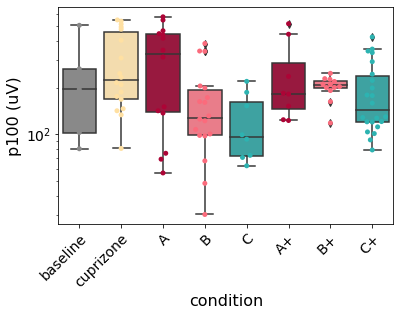

In [98]:
df2 = df[df.VEP_quality==1]
f,ax = plt.subplots(1,1)
plt.rcParams["axes.labelsize"] = 16
df3 = df2[df2.n70_latency>0.1]
sns.boxplot(data=df3,x='condition',y='p100_amplitude',order=order,ax=ax)
sns.swarmplot(data=df3,x='condition',y='p100_amplitude',order=order,ax=ax)
plt.yticks(fontsize=14)
ax.set_ylabel('p100 (uV)')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14,rotation=45,ha='right', rotation_mode='anchor')
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
# ax.set_ylim(-5000,0)
ax.set_yscale('log')

In [87]:
df.head()

,mouse,probe,sign,condition,n70_latency,p100_latency,n70_amplitude,p100_amplitude,n70_amplitude_area,p100_slope,n70_slope,on_latency,on_amplitude,sigma_total,sigma_baseline,sigma_evoked,VEP,VEP_quality
0,3583,0,bright,baseline,0.099320,0.217767,-465.625000,568.203125,-43035.069679,8728.163799,-13779.689700,0.063305,-30.642336,208.242781,30.642336,230.279625,"[-31.302455057226, -31.260903714345332, -31.17...",1
1,3583,0,dark,baseline,0.080512,0.193758,-419.062500,417.578125,-1024.234118,7387.861915,-4020.189599,-0.027531,-15.291718,153.611614,15.291718,171.125344,"[7.779644556482399, 7.805390871883628, 7.85670...",1
2,3583,1,bright,baseline,0.108523,0.246979,-317.343750,506.640625,-87477.746822,5951.262870,-7292.747424,0.062905,-15.338605,163.430109,15.338605,178.679937,"[0.1834339617227414, 0.1622743055131366, 0.119...",1
3,3583,1,dark,baseline,0.096118,0.216967,-342.734375,396.484375,-10685.508602,6116.912769,-8211.418391,0.052501,-15.426731,124.582180,15.426731,138.552621,"[-7.180784298971384, -7.174858803277054, -7.16...",1
4,3590,1,bright,cuprizone,0.107723,0.249380,-238.671875,405.546875,-23717.444355,4547.747617,-1942.406546,-0.020328,-10.055654,140.312078,10.055654,156.232508,"[-19.405336276390553, -19.395184732920775, -19...",1


In [95]:
df.to_csv('/Users/danieldenman/Desktop/df_withVEPs.csv')